## Carregar módulos necessários para o estudo

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

print(pd)
print(np)
print(plt)
print(sns)
print(ArmaProcess)
print(CausalImpact)

<module 'pandas' from '/home/chico_linux/.local/lib/python3.10/site-packages/pandas/__init__.py'>
<module 'numpy' from '/home/chico_linux/.local/lib/python3.10/site-packages/numpy/__init__.py'>
<module 'matplotlib.pyplot' from '/home/chico_linux/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>
<module 'seaborn' from '/home/chico_linux/.local/lib/python3.10/site-packages/seaborn/__init__.py'>
<class 'statsmodels.tsa.arima_process.ArmaProcess'>
<class 'causalimpact.main.CausalImpact'>


## Carregar as bases de dados necessárias

A base de dados do preço do combustível nas refinarias e importadoras, extraído desse site [aqui](https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-de-produtores-e-importadores-de-derivados-de-petroleo). Há outra [base](https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/serie-historica-do-levantamento-de-precos), relacionada a dados de de postos de gasolina (final da cadeia), mas não é relevante usar no experimento. 

In [33]:
plant = pd.read_excel("https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/ppidp/precos-medios-ponderados-semanais-2013.xls",
                      engine="xlrd",
                      skiprows=8,
                      skipfooter=8,
                      usecols="A:I",
                      na_values="***",
                      names=["product", "from_", "until", "north", "northeast", "midwest", "south", "southeast", "brazil"])

plant

,product,from_,until,north,northeast,midwest,south,southeast,brazil
0,Asfalto Diluído de Petróleo de Cura Média 30 (...,2012-12-31,2013-01-06,1.29360,1.29360,NaN,1.29360,1.29360,1.29360
1,Asfalto Diluído de Petróleo de Cura Média 30 (...,2013-01-07,2013-01-13,1.29360,1.29360,NaN,1.29360,1.29360,1.29360
2,Asfalto Diluído de Petróleo de Cura Média 30 (...,2013-01-14,2013-01-20,1.29360,1.29360,NaN,1.29360,1.29360,1.29360
3,Asfalto Diluído de Petróleo de Cura Média 30 (...,2013-01-21,2013-01-27,1.29360,1.29360,NaN,1.29360,1.29360,1.29360
4,Asfalto Diluído de Petróleo de Cura Média 30 (...,2013-01-28,2013-02-03,1.29360,1.29360,NaN,1.29360,1.29360,1.29360
...,...,...,...,...,...,...,...,...,...
8902,Querosene de Aviação - QAV (R$/litro),2023-07-03,2023-07-09,3.43668,3.34133,NaN,3.47815,3.46374,3.44711
8903,Querosene de Aviação - QAV (R$/litro),2023-07-10,2023-07-16,3.42461,3.26774,NaN,3.45461,3.45236,3.44563
8904,Querosene de Aviação - QAV (R$/litro),2023-07-17,2023-07-23,3.54543,3.37457,NaN,3.48249,3.40205,3.40921
8905,Querosene de Aviação - QAV (R$/litro),2023-07-24,2023-07-30,3.83527,3.32598,NaN,3.47986,3.40239,3.40927


Tudo certo para usar! =D

Agora baixe os dados de preços de petróleo do tipo WTI, do tipo leve e pouco sulfuroso (`Cushing, OK WTI Spot Price FOB (Dollars per Barrel)`). Dessa cotação que podemos extrair uma variável de controle, pois a Petrobrás compra combustível do tipo leve para refinar e produzir combustível como gasolina e diesel.

In [34]:
oil = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RWTCd.xls", 
                    sheet_name="Data 1",
                    skiprows=2,
                    names=["day", "wti_price"])

oil

,day,wti_price
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87
...,...,...
9467,2023-08-01,81.37
9468,2023-08-02,79.50
9469,2023-08-03,81.56
9470,2023-08-04,82.76


## Faça o EDA para entender melhor sobre os dados extraídos

In [35]:
plant["product"].drop_duplicates()

0       Asfalto Diluído de Petróleo de Cura Média 30 (...
553     Asfalto Diluído de Petróleo de Cura Rápida 250...
709                            Biodiesel B-100 (R$/litro)
792           Cimento Asfáltico de Petróleo 30 45 (R$/kg)
1345          Cimento Asfáltico de Petróleo 50 70 (R$/kg)
1898             Gás Liquefeito de Petróleo - GLP (R$/kg)
3199                          Gasolina A Comum (R$/litro)
3752                        Gasolina A Premium (R$/litro)
4008                           Nafta Petroquímica (R$/kg)
4060                           Nafta Petroquímica (R$/Kg)
4561                          Óleo Combustível A1 (R$/kg)
5114                          Óleo Combustível A2 (R$/kg)
5219                          Óleo Combustível B1 (R$/kg)
5675                          Óleo Combustível B2 (R$/kg)
5952              Óleo Diesel Marítimo DMA-MGO (R$/litro)
6505                Óleo Diesel Não Rodoviário (R$/litro)
6645                          Óleo Diesel S-10 (R$/litro)
7198          

As distribuidoras de combustível compram nas refinarias a gasolina tipo “A”. Atendendo à legislação brasileira, a gasolina vendida nos postos deve ser misturada com Etanol Anidro. Desta maneira, no preço que o consumidor paga está incluído o preço de realização da Petrobras, o custo do etanol (que é definido livremente pelos seus produtores) e os custos e as margens de comercialização das distribuidoras e dos postos revendedores, bem como todos os impostos devidos.

Filtre por `Gasolina A Comum`. 

As distribuidoras de combustível compram nas refinarias o diesel tipo “A”, que é o óleo diesel S-10 com teor máximo de enxofre de 10mg/kg (ppm = partes por milhão): desenvolvido para motores a diesel emitirem menores teores de material particulado e NOx do que os da geração anterior.

Atendendo à legislação brasileira, o diesel automotivo vendido no Brasil deve ser misturado com biodiesel, um combustível renovável produzido a partir de óleos vegetais ou gorduras animais, formando o óleo diesel “B”, que é revendido nos postos. No preço que o consumidor paga no posto, portanto, além dos impostos e da parcela Petrobras, estão incluídos também o custo de aquisição do biodiesel e os custos e margens de comercialização das distribuidoras e dos revendedores.

Filtre também pelo `Óleo Diesel S-10`

In [36]:
plant_sel = plant[plant["product"].isin(["Gasolina A Comum (R$/litro)", "Óleo Diesel S-10 (R$/litro)"])].\
    copy().\
    drop(columns=["north", "northeast", "midwest", "south", "southeast"]).\
    rename(columns={"brazil": "price"}) # Vamos usar o preço do Brasil
plant_sel = plant_sel[plant_sel.from_ >= "2022-01-01"]

plant_sel

,product,from_,until,price
3669,Gasolina A Comum (R$/litro),2022-01-03,2022-01-09,4.10261
3670,Gasolina A Comum (R$/litro),2022-01-10,2022-01-16,4.17026
3671,Gasolina A Comum (R$/litro),2022-01-17,2022-01-23,4.19075
3672,Gasolina A Comum (R$/litro),2022-01-24,2022-01-30,4.21726
3673,Gasolina A Comum (R$/litro),2022-01-31,2022-02-06,4.23894
...,...,...,...,...
7193,Óleo Diesel S-10 (R$/litro),2023-07-03,2023-07-09,3.08891
7194,Óleo Diesel S-10 (R$/litro),2023-07-10,2023-07-16,3.10523
7195,Óleo Diesel S-10 (R$/litro),2023-07-17,2023-07-23,3.08251
7196,Óleo Diesel S-10 (R$/litro),2023-07-24,2023-07-30,3.10315


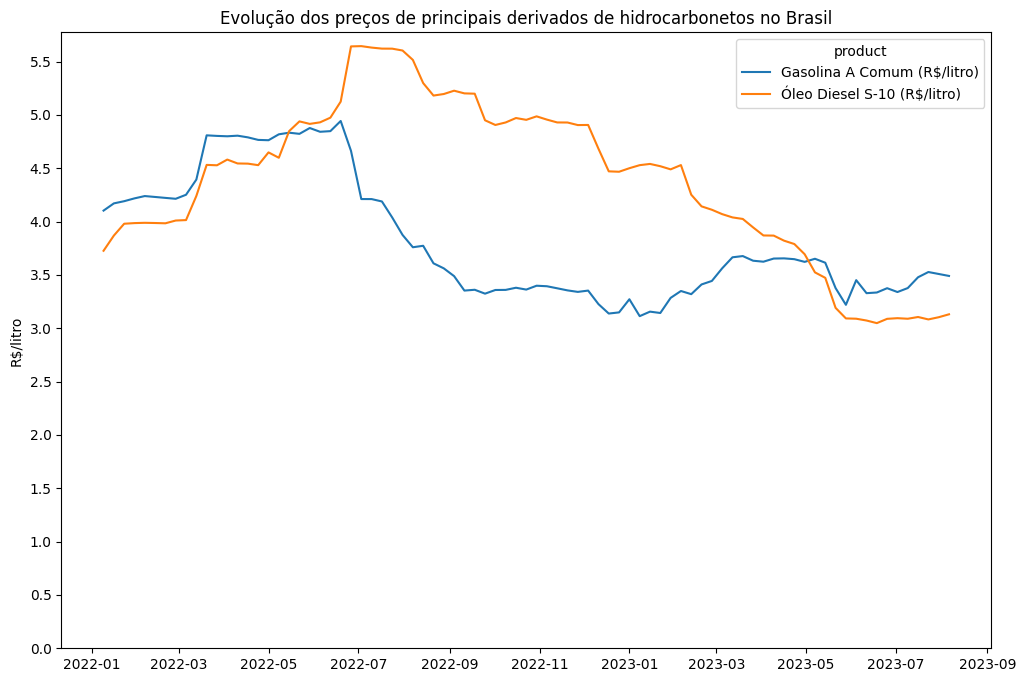

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    x="until", 
    y="price",
    hue="product",
    data=plant_sel
)

plt.xlabel("", size=10)
plt.ylabel("R$/litro", size=10)

ax.set_title("Evolução dos preços de principais derivados de hidrocarbonetos no Brasil")
ax.set_yticks(np.arange(0, 6 , 0.5))

Veja a evolução dos preço do barril de petróleo WTI

Text(0.5, 1.0, 'Evolução do preço de barril de petróleo - WTI')

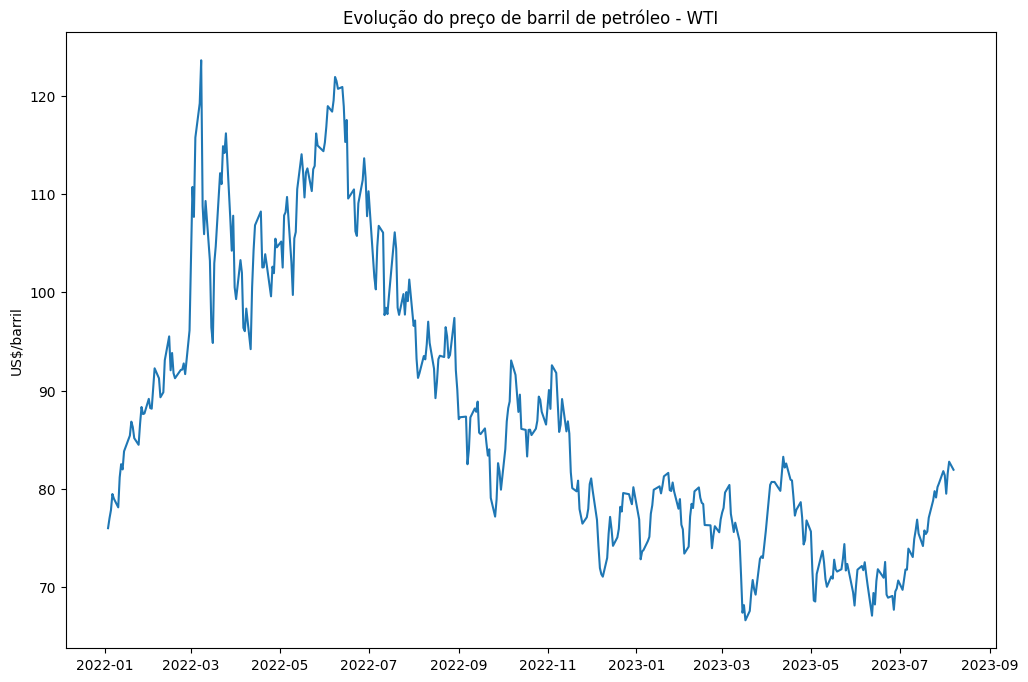

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    x="day", 
    y="wti_price",
    data=oil[oil.day >= "2022-01-01"]
)

plt.xlabel("", size=10)
plt.ylabel("US$/barril", size=10)

ax.set_title("Evolução do preço de barril de petróleo - WTI")

Veja graficamente o preço da gasolina e diesel em relação ao do barril de petróleo. Só que isso está numa periodicidade diferente da outra base, a fim de fazermos uma comparação, logo deixe as bases em termos temporais semelhantes. 

Faça a base de petróleo ter uma média, com base no período de pesquisa da base de combustíveis do Brasil.

In [39]:
oil_avg = plant_sel[["from_", "until"]].drop_duplicates().copy()

oil_avg = oil_avg.merge(oil[oil.day >= "2022-01-01"], how="cross")

oil_avg = oil_avg[oil_avg.day.between(oil_avg.from_, oil_avg.until)].groupby(["from_", "until"], as_index=False).agg({"wti_price": "mean"})

oil_avg

,from_,until,wti_price
0,2022-01-03,2022-01-09,77.8580
1,2022-01-10,2022-01-16,81.5160
2,2022-01-17,2022-01-23,85.9275
3,2022-01-24,2022-01-30,86.9400
4,2022-01-31,2022-02-06,89.5960
...,...,...,...
78,2023-07-03,2023-07-09,71.7900
79,2023-07-10,2023-07-16,75.1980
80,2023-07-17,2023-07-23,75.6080
81,2023-07-24,2023-07-30,79.6800


Agora faça o gráfico

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


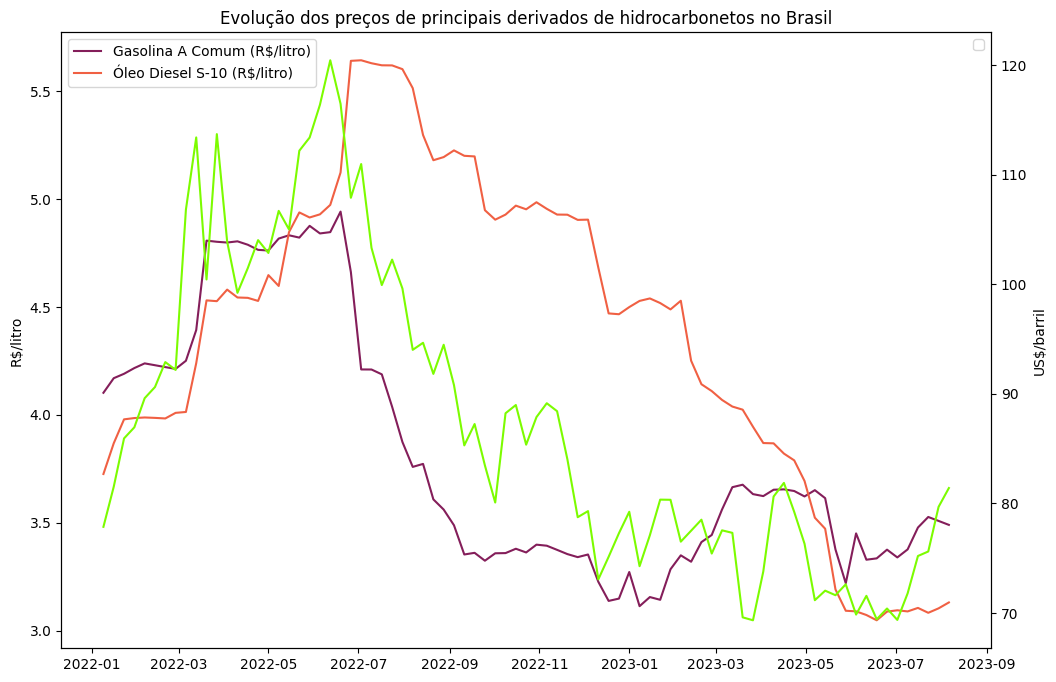

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))

ax2 = ax.twinx()

sns.lineplot(
    x="until", 
    y="price",
    hue="product",
    palette="rocket",
    ax = ax,
    data=plant_sel
)

sns.lineplot(
    x="until", 
    y="wti_price",
    color="lawngreen",
    # legend=False,
    ax = ax2,
    data=oil_avg
)

ax.set_title("Evolução dos preços de principais derivados de hidrocarbonetos no Brasil")
ax.set_xlabel('')
ax.set_ylabel('R$/litro', size=10)
ax2.set_ylabel('US$/barril', size=10)

ax.legend(loc="upper left")
ax2.legend(loc="upper right")

Estão todos bem correlacionados, e isso dá segurança para usar o preço do petróleo WTI como variável de controle para o preço dos derivados de combustíveis. 

O 3º governo Lula começou a ["abrasileirar" os preços dos combustíveis](https://youtu.be/kDxKYqQWAps) a partir de 16 de maio de 2023, com reduções de 12% nos preços da gasolina e do diesel. Vamos ver se isso é visualizado graficamente.  

Text(0.5, 1.0, 'Evolução dos preços de principais derivados de hidrocarbonetos no Brasil')

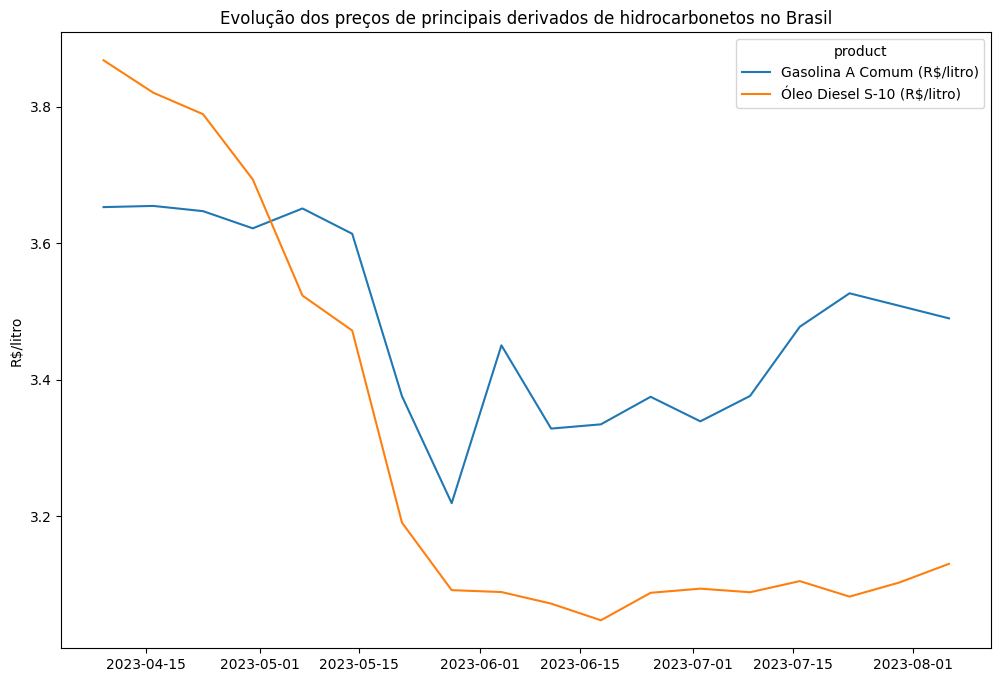

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    x="until", 
    y="price",
    hue="product",
    data=plant_sel[plant_sel.from_ >= "2023-04-01"]
)

plt.xlabel("", size=10)
plt.ylabel("R$/litro", size=10)

ax.set_title("Evolução dos preços de principais derivados de hidrocarbonetos no Brasil")

Dá para observar que houve essa redução. 

## Vamos aplicar a inferência causal sobre o preço de cada um dos derivados de hidrocarbonetos. 

É preciso construir uma base de periodicidade diária. 

In [54]:
cake_pan = pd.date_range("2022-01-01", "2023-08-07")
cake_pan = pd.DataFrame(cake_pan, columns=["day"])

In [55]:
gasoline = plant_sel[(plant_sel["product"] == "Gasolina A Comum (R$/litro)")].copy()

gasoline = cake_pan.merge(oil, how="left", on="day").\
                    merge(gasoline, how="cross")

gasoline = gasoline[gasoline.day.between(gasoline.from_, gasoline.until) & (gasoline.wti_price.notna())].\
            rename(columns = {"price": "gas_price"}).\
            drop(columns=["product", "until", "from_"])
            
gasoline = gasoline[gasoline.day >= "2023-01-01"][["day", "gas_price", "wti_price"]]

gasoline = gasoline.set_index(["day"])

Especifique as janelas de análise: o antes e depois da intervenção (tratamento). 

In [56]:
pre_period=["2023-01-03", "2023-05-15"]

pre_period

['2023-01-03', '2023-05-15']

In [57]:
post_period=["2023-05-16", "2023-08-04"]

post_period

['2023-05-16', '2023-08-04']

Rode o modelo

In [58]:
impact = CausalImpact(gasoline, pre_period, post_period, 
                        model_args={"prior_level_sd": None # Configure isso como None, conforme a documentação
                                    } 
                     )
# impact = CausalImpact(gasoline, pre_period, post_period, 
#                         model_args={"prior_level_sd": None, 
#                                     "nseasons": 5,
#                                     "season_duration": 1} 
#                      )

# impact.run() # Caso seja necessário para rodar o modelo

/home/chico_linux/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/chico_linux/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: model_args, standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
/home/chico_linux/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/chico_linux/.local/lib/pyt

In [59]:
# impact.inferences

In [60]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    3.4                190.44
Prediction (s.d.)         3.54 (0.03)        198.51 (1.76)
95% CI                    [3.48, 3.61]       [195.05, 201.93]

Absolute effect (s.d.)    -0.14 (0.03)       -8.07 (1.76)
95% CI                    [-0.21, -0.08]     [-11.49, -4.61]

Relative effect (s.d.)    -4.06% (0.88%)     -4.06% (0.88%)
95% CI                    [-5.79%, -2.32%]   [-5.79%, -2.32%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [61]:
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 3.4. By contrast, in the absence of an
intervention, we would have expected an average response of 3.54.
The 95% interval of this counterfactual prediction is [3.48, 3.61].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -0.14 with a 95% interval of
[-0.21, -0.08]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 190.44.
By contrast, had the intervention not taken place, we would have expected
a sum of 198.51. The 95% interval of this prediction is [195.05, 201.93].


The above results are given in terms of absolute numbers. In relative
terms, the response variable sh

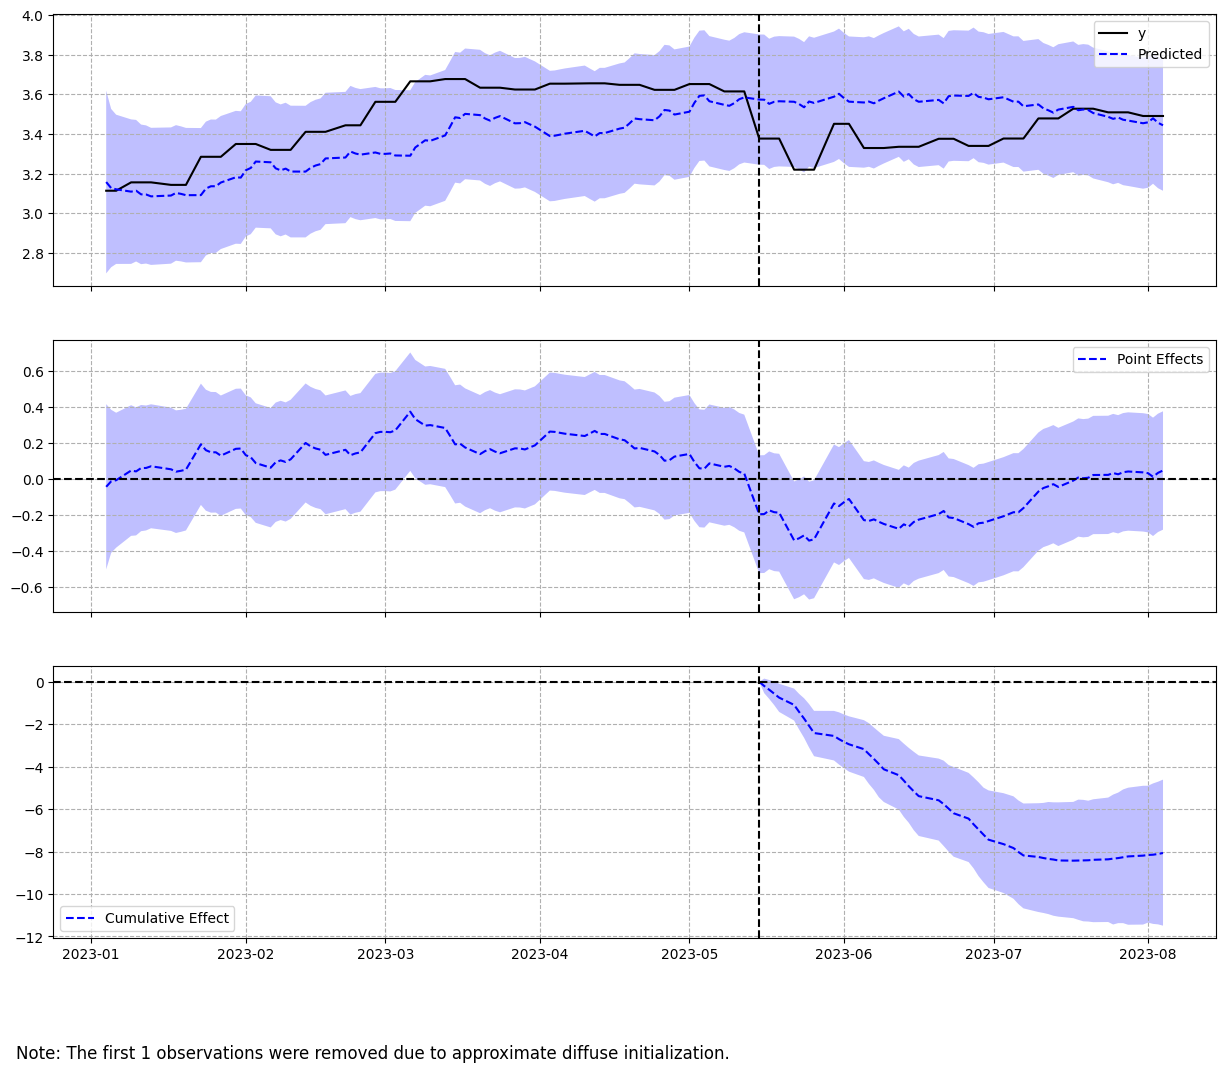

In [62]:
impact.plot()